# 데모

## 라이브러리 import 및 설정

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [14]:
from lightgbm import LGBMClassifier
from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np
import optuna.integration.lightgbm as lgb
from pathlib import Path
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold, train_test_split
import seaborn as sns
import warnings

In [3]:
rcParams['figure.figsize'] = (16, 8)
plt.style.use('fivethirtyeight')
pd.set_option('max_columns', 100)
pd.set_option("display.precision", 4)
warnings.simplefilter('ignore')

## 학습데이터 로드

[03-pandas-eda.ipynb](https://github.com/kaggler-tv/dku-kaggle-class/blob/master/notebook/03-pandas-eda.ipynb)에서 생성한 `feature.csv` 피처파일 사용

In [4]:
data_dir = Path('../data/dacon-dku')
feature_dir = Path('../build/feature')
val_dir = Path('../build/val')
tst_dir = Path('../build/tst')
sub_dir = Path('../build/sub')

trn_file = data_dir / 'train.csv'
tst_file = data_dir / 'test.csv'
sample_file = data_dir / 'sample_submission.csv'

target_col = 'class'
n_fold = 5
n_class = 3
seed = 42

In [5]:
algo_name = 'lgb_optuna'
feature_name = 'feature'
model_name = f'{algo_name}_{feature_name}'

feature_file = feature_dir / f'{feature_name}.csv'
p_val_file = val_dir / f'{model_name}.val.csv'
p_tst_file = tst_dir / f'{model_name}.tst.csv'
sub_file = sub_dir / f'{model_name}.csv'

In [6]:
df = pd.read_csv(feature_file, index_col=0)
print(df.shape)
df.head()

(400000, 20)


,z,redshift,dered_u,dered_g,dered_r,dered_i,dered_z,nObserve,airmass_u,class,d_dered_u,d_dered_g,d_dered_r,d_dered_i,d_dered_z,d_dered_ig,d_dered_zg,d_dered_rz,d_dered_iz,d_obs_det
id,,,,,,,,,,,,,,,,,,,,
0,16.9396,-8.1086e-05,23.1243,20.2578,18.9551,17.6321,16.9089,2.9444,1.1898,0.0,-0.1397,-0.0790,-0.0544,-0.0403,-0.0307,-2.6257,-3.3488,2.0462,0.7232,-15.0556
1,13.1689,4.5061e-03,14.9664,14.0045,13.4114,13.2363,13.1347,0.6931,1.2533,1.0,-0.0857,-0.0574,-0.0410,-0.0322,-0.0343,-0.7683,-0.8698,0.2767,0.1016,-0.3069
2,15.3500,4.7198e-04,16.6076,15.6866,15.4400,15.3217,15.2961,1.0986,1.0225,0.0,-0.1787,-0.1388,-0.0963,-0.0718,-0.0540,-0.3649,-0.3905,0.1440,0.0257,-0.9014
3,19.6346,5.8143e-06,25.3536,20.9947,20.0873,19.7947,19.5552,1.6094,1.2054,0.0,-0.3070,-0.1941,-0.1339,-0.1003,-0.0795,-1.2000,-1.4395,0.5321,0.2395,-1.3906
4,17.9826,-3.3247e-05,23.7714,20.4338,18.8630,18.1903,17.8759,2.6391,1.1939,0.0,-0.6820,-0.2653,-0.1794,-0.1339,-0.1067,-2.2436,-2.5579,0.9871,0.3144,-9.3609


In [7]:
y = df[target_col].values[:320000]
df.drop(target_col, axis=1, inplace=True)
trn = df.iloc[:320000].values
tst = df.iloc[320000:].values
feature_name = df.columns.tolist()
print(y.shape, trn.shape, tst.shape)

(320000,) (320000, 19) (80000, 19)


## Hyperparameter Tuning

In [8]:
X_trn, X_val, y_trn, y_val = train_test_split(trn, y, test_size=.2, random_state=seed)

In [9]:
params = {
    "objective": "multiclass",
    "metric": "multi_logloss",
    "num_class": 3,
    "n_estimators": 1000,
    "subsample_freq": 1,
    "lambda_l1": 0.,
    "lambda_l2": 0.,
    "random_state": seed,
    "n_jobs": -1,
}

In [10]:
dtrain = lgb.Dataset(X_trn, label=y_trn)
dval = lgb.Dataset(X_val, label=y_val)

model = lgb.train(params, dtrain, valid_sets=[dtrain, dval], 
                  verbose_eval=100, early_stopping_rounds=10)

prediction = np.argmax(model.predict(X_val, num_iteration=model.best_iteration), 
                       axis=1)
accuracy = accuracy_score(y_val, prediction)

params = model.params
print("Best params:", params)
print("  Accuracy = {}".format(accuracy))
print("  Params: ")
for key, value in params.items():
    print("    {}: {}".format(key, value))

[I 2020-10-05 01:38:56,754] A new study created in memory with name: no-name-6a091e98-0e25-46bd-a749-ed1a9211b661
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.162292	valid_1's multi_logloss: 0.173038
[200]	training's multi_logloss: 0.147386	valid_1's multi_logloss: 0.166751
[300]	training's multi_logloss: 0.138664	valid_1's multi_logloss: 0.165094
[400]	training's multi_logloss: 0.131529	valid_1's multi_logloss: 0.164127
Early stopping, best iteration is:
[409]	training's multi_logloss: 0.130959	valid_1's multi_logloss: 0.164059


feature_fraction, val_score: 0.164059:  14%|#4        | 1/7 [00:11<01:09, 11.58s/it]

Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.164111	valid_1's multi_logloss: 0.174182
[200]	training's multi_logloss: 0.148453	valid_1's multi_logloss: 0.16733
[300]	training's multi_logloss: 0.139438	valid_1's multi_logloss: 0.165289
[400]	training's multi_logloss: 0.132501	valid_1's multi_logloss: 0.164311
[500]	training's multi_logloss: 0.126573	valid_1's multi_logloss: 0.163827
Early stopping, best iteration is:
[492]	training's multi_logloss: 0.127006	valid_1's multi_logloss: 0.163806


feature_fraction, val_score: 0.163806:  29%|##8       | 2/7 [00:25<01:01, 12.38s/it]

Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.16075	valid_1's multi_logloss: 0.17161
Early stopping, best iteration is:
[105]	training's multi_logloss: 0.159637	valid_1's multi_logloss: 0.170937


feature_fraction, val_score: 0.163806:  43%|####2     | 3/7 [00:29<00:39,  9.91s/it]

Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.165649	valid_1's multi_logloss: 0.175603
[200]	training's multi_logloss: 0.149261	valid_1's multi_logloss: 0.167375
[300]	training's multi_logloss: 0.140256	valid_1's multi_logloss: 0.165219
[400]	training's multi_logloss: 0.133317	valid_1's multi_logloss: 0.164255
[500]	training's multi_logloss: 0.127339	valid_1's multi_logloss: 0.163815
Early stopping, best iteration is:
[531]	training's multi_logloss: 0.125601	valid_1's multi_logloss: 0.163628


feature_fraction, val_score: 0.163628:  57%|#####7    | 4/7 [00:47<00:36, 12.16s/it]

Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.160287	valid_1's multi_logloss: 0.171711
Early stopping, best iteration is:
[130]	training's multi_logloss: 0.154765	valid_1's multi_logloss: 0.169293


feature_fraction, val_score: 0.163628:  71%|#######1  | 5/7 [00:57<00:23, 11.58s/it]

Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.161738	valid_1's multi_logloss: 0.173028
Early stopping, best iteration is:
[114]	training's multi_logloss: 0.158324	valid_1's multi_logloss: 0.170882


feature_fraction, val_score: 0.163628:  86%|########5 | 6/7 [01:02<00:09,  9.64s/it]

Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.170758	valid_1's multi_logloss: 0.180113
[200]	training's multi_logloss: 0.152064	valid_1's multi_logloss: 0.168935
[300]	training's multi_logloss: 0.14251	valid_1's multi_logloss: 0.165979
[400]	training's multi_logloss: 0.135389	valid_1's multi_logloss: 0.164762
Early stopping, best iteration is:
[464]	training's multi_logloss: 0.131513	valid_1's multi_logloss: 0.164176


num_leaves, val_score: 0.163628:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.150085	valid_1's multi_logloss: 0.16878
[200]	training's multi_logloss: 0.130683	valid_1's multi_logloss: 0.16386
Early stopping, best iteration is:
[262]	training's multi_logloss: 0.122812	valid_1's multi_logloss: 0.163395


num_leaves, val_score: 0.163395:   5%|5         | 1/20 [00:09<03:08,  9.90s/it]

Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.13437	valid_1's multi_logloss: 0.165749
Early stopping, best iteration is:
[183]	training's multi_logloss: 0.11309	valid_1's multi_logloss: 0.162617


num_leaves, val_score: 0.162617:  10%|#         | 2/20 [00:18<02:51,  9.50s/it]

Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.147506	valid_1's multi_logloss: 0.168034
[200]	training's multi_logloss: 0.127448	valid_1's multi_logloss: 0.163461
Early stopping, best iteration is:
[248]	training's multi_logloss: 0.120832	valid_1's multi_logloss: 0.16294


num_leaves, val_score: 0.162617:  15%|#5        | 3/20 [00:29<02:48,  9.89s/it]

Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.113822	valid_1's multi_logloss: 0.163663
Early stopping, best iteration is:
[142]	training's multi_logloss: 0.0983114	valid_1's multi_logloss: 0.162338


num_leaves, val_score: 0.162338:  20%|##        | 4/20 [00:43<02:58, 11.16s/it]

Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.115402	valid_1's multi_logloss: 0.163998
Early stopping, best iteration is:
[165]	training's multi_logloss: 0.093376	valid_1's multi_logloss: 0.162661


num_leaves, val_score: 0.162338:  25%|##5       | 5/20 [00:53<02:44, 10.95s/it]

Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.121582	valid_1's multi_logloss: 0.164385
Early stopping, best iteration is:
[165]	training's multi_logloss: 0.101027	valid_1's multi_logloss: 0.162603


num_leaves, val_score: 0.162338:  30%|###       | 6/20 [01:03<02:27, 10.51s/it]

Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.11569	valid_1's multi_logloss: 0.163916
Early stopping, best iteration is:
[154]	training's multi_logloss: 0.0968509	valid_1's multi_logloss: 0.162224


num_leaves, val_score: 0.162224:  35%|###5      | 7/20 [01:13<02:14, 10.34s/it]

Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.112095	valid_1's multi_logloss: 0.16367
Early stopping, best iteration is:
[142]	training's multi_logloss: 0.0962171	valid_1's multi_logloss: 0.162379


num_leaves, val_score: 0.162224:  40%|####      | 8/20 [01:22<02:00, 10.05s/it]

Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.119369	valid_1's multi_logloss: 0.164238
Early stopping, best iteration is:
[158]	training's multi_logloss: 0.100064	valid_1's multi_logloss: 0.162377


num_leaves, val_score: 0.162224:  45%|####5     | 9/20 [01:31<01:47,  9.79s/it]

Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.129841	valid_1's multi_logloss: 0.165067
[200]	training's multi_logloss: 0.103666	valid_1's multi_logloss: 0.162631
Early stopping, best iteration is:
[195]	training's multi_logloss: 0.104686	valid_1's multi_logloss: 0.162603


num_leaves, val_score: 0.162224:  50%|#####     | 10/20 [01:41<01:37,  9.79s/it]

Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.112095	valid_1's multi_logloss: 0.16367
Early stopping, best iteration is:
[142]	training's multi_logloss: 0.0962171	valid_1's multi_logloss: 0.162379


num_leaves, val_score: 0.162224:  55%|#####5    | 11/20 [01:51<01:29,  9.90s/it]

Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.125475	valid_1's multi_logloss: 0.16473
Early stopping, best iteration is:
[156]	training's multi_logloss: 0.108027	valid_1's multi_logloss: 0.162763


num_leaves, val_score: 0.162224:  60%|######    | 12/20 [02:01<01:18,  9.78s/it]

Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.112095	valid_1's multi_logloss: 0.16367
Early stopping, best iteration is:
[142]	training's multi_logloss: 0.0962171	valid_1's multi_logloss: 0.162379


num_leaves, val_score: 0.162224:  65%|######5   | 13/20 [02:11<01:10, 10.02s/it]

Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.118248	valid_1's multi_logloss: 0.164028
Early stopping, best iteration is:
[159]	training's multi_logloss: 0.0983824	valid_1's multi_logloss: 0.162364


num_leaves, val_score: 0.162224:  70%|#######   | 14/20 [02:23<01:02, 10.42s/it]

Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.11743	valid_1's multi_logloss: 0.164095
Early stopping, best iteration is:
[158]	training's multi_logloss: 0.0974664	valid_1's multi_logloss: 0.162342


num_leaves, val_score: 0.162224:  75%|#######5  | 15/20 [02:34<00:53, 10.68s/it]

Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.11553	valid_1's multi_logloss: 0.16354
Early stopping, best iteration is:
[155]	training's multi_logloss: 0.0964272	valid_1's multi_logloss: 0.162102


num_leaves, val_score: 0.162102:  80%|########  | 16/20 [02:45<00:43, 10.88s/it]

Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.176055	valid_1's multi_logloss: 0.18274
[200]	training's multi_logloss: 0.159619	valid_1's multi_logloss: 0.171477
Early stopping, best iteration is:
[215]	training's multi_logloss: 0.158132	valid_1's multi_logloss: 0.170663


num_leaves, val_score: 0.162102:  85%|########5 | 17/20 [02:53<00:29,  9.97s/it]

Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.124357	valid_1's multi_logloss: 0.16471
Early stopping, best iteration is:
[166]	training's multi_logloss: 0.104317	valid_1's multi_logloss: 0.162603


num_leaves, val_score: 0.162102:  90%|######### | 18/20 [03:05<00:20, 10.39s/it]

Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.114898	valid_1's multi_logloss: 0.163815
Early stopping, best iteration is:
[153]	training's multi_logloss: 0.096125	valid_1's multi_logloss: 0.162262


num_leaves, val_score: 0.162102:  95%|#########5| 19/20 [03:16<00:10, 10.78s/it]

Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.135095	valid_1's multi_logloss: 0.165697
Early stopping, best iteration is:
[173]	training's multi_logloss: 0.115912	valid_1's multi_logloss: 0.16288


bagging, val_score: 0.162102:   0%|          | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.115842	valid_1's multi_logloss: 0.163836
Early stopping, best iteration is:
[159]	training's multi_logloss: 0.0949288	valid_1's multi_logloss: 0.162088


bagging, val_score: 0.162088:  10%|#         | 1/10 [00:10<01:38, 10.96s/it]

Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.115669	valid_1's multi_logloss: 0.164101
Early stopping, best iteration is:
[157]	training's multi_logloss: 0.0951842	valid_1's multi_logloss: 0.162401


bagging, val_score: 0.162088:  20%|##        | 2/10 [00:21<01:26, 10.82s/it]

Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.117368	valid_1's multi_logloss: 0.164542
Early stopping, best iteration is:
[149]	training's multi_logloss: 0.0989798	valid_1's multi_logloss: 0.163361


bagging, val_score: 0.162088:  30%|###       | 3/10 [00:31<01:13, 10.51s/it]

Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.115516	valid_1's multi_logloss: 0.163795
Early stopping, best iteration is:
[155]	training's multi_logloss: 0.0961473	valid_1's multi_logloss: 0.162374


bagging, val_score: 0.162088:  40%|####      | 4/10 [00:42<01:05, 10.85s/it]

Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.1162	valid_1's multi_logloss: 0.164003
Early stopping, best iteration is:
[148]	training's multi_logloss: 0.0985721	valid_1's multi_logloss: 0.162386


bagging, val_score: 0.162088:  50%|#####     | 5/10 [00:53<00:53, 10.74s/it]

Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.118878	valid_1's multi_logloss: 0.164902
Early stopping, best iteration is:
[134]	training's multi_logloss: 0.105612	valid_1's multi_logloss: 0.163776


bagging, val_score: 0.162088:  60%|######    | 6/10 [01:02<00:40, 10.24s/it]

Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.116585	valid_1's multi_logloss: 0.164377
Early stopping, best iteration is:
[144]	training's multi_logloss: 0.0997517	valid_1's multi_logloss: 0.163076


bagging, val_score: 0.162088:  70%|#######   | 7/10 [01:12<00:30, 10.19s/it]

Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.115468	valid_1's multi_logloss: 0.1639
Early stopping, best iteration is:
[155]	training's multi_logloss: 0.0959966	valid_1's multi_logloss: 0.162265


bagging, val_score: 0.162088:  80%|########  | 8/10 [01:23<00:20, 10.40s/it]

Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.117607	valid_1's multi_logloss: 0.164824
Early stopping, best iteration is:
[149]	training's multi_logloss: 0.0992214	valid_1's multi_logloss: 0.163512


bagging, val_score: 0.162088:  90%|######### | 9/10 [01:33<00:10, 10.26s/it]

Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.115761	valid_1's multi_logloss: 0.164004
Early stopping, best iteration is:
[165]	training's multi_logloss: 0.0930721	valid_1's multi_logloss: 0.162492


feature_fraction_stage2, val_score: 0.162088:   0%|          | 0/6 [00:00<?, ?it/s]

Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.115842	valid_1's multi_logloss: 0.163836
Early stopping, best iteration is:
[159]	training's multi_logloss: 0.0949288	valid_1's multi_logloss: 0.162088


feature_fraction_stage2, val_score: 0.162088:  17%|#6        | 1/6 [00:10<00:54, 10.87s/it]

Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.120798	valid_1's multi_logloss: 0.166608
Early stopping, best iteration is:
[187]	training's multi_logloss: 0.0909902	valid_1's multi_logloss: 0.163141


feature_fraction_stage2, val_score: 0.162088:  33%|###3      | 2/6 [00:23<00:45, 11.46s/it]

Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.117827	valid_1's multi_logloss: 0.164479
Early stopping, best iteration is:
[144]	training's multi_logloss: 0.101044	valid_1's multi_logloss: 0.1624


feature_fraction_stage2, val_score: 0.162088:  50%|#####     | 3/6 [00:34<00:33, 11.12s/it]

Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.117827	valid_1's multi_logloss: 0.164479
Early stopping, best iteration is:
[144]	training's multi_logloss: 0.101044	valid_1's multi_logloss: 0.1624


feature_fraction_stage2, val_score: 0.162088:  67%|######6   | 4/6 [00:44<00:21, 10.87s/it]

Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.114238	valid_1's multi_logloss: 0.163253
Early stopping, best iteration is:
[147]	training's multi_logloss: 0.0974959	valid_1's multi_logloss: 0.162036


feature_fraction_stage2, val_score: 0.162036:  83%|########3 | 5/6 [00:54<00:10, 10.73s/it]

Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.115842	valid_1's multi_logloss: 0.163836
Early stopping, best iteration is:
[159]	training's multi_logloss: 0.0949288	valid_1's multi_logloss: 0.162088


regularization_factors, val_score: 0.162036:   0%|          | 0/20 [00:00<?, ?it/s]

Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.11423	valid_1's multi_logloss: 0.163224
Early stopping, best iteration is:
[137]	training's multi_logloss: 0.100596	valid_1's multi_logloss: 0.16214


regularization_factors, val_score: 0.162036:   5%|5         | 1/20 [00:10<03:14, 10.23s/it]

Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.13737	valid_1's multi_logloss: 0.165753
[200]	training's multi_logloss: 0.115654	valid_1's multi_logloss: 0.162753
Early stopping, best iteration is:
[201]	training's multi_logloss: 0.115488	valid_1's multi_logloss: 0.162735


regularization_factors, val_score: 0.162036:  10%|#         | 2/20 [00:24<03:23, 11.33s/it]

Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.123488	valid_1's multi_logloss: 0.163763
Early stopping, best iteration is:
[170]	training's multi_logloss: 0.10233	valid_1's multi_logloss: 0.162141


regularization_factors, val_score: 0.162036:  15%|#5        | 3/20 [00:36<03:16, 11.54s/it]

Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.1238	valid_1's multi_logloss: 0.164048
Early stopping, best iteration is:
[155]	training's multi_logloss: 0.106531	valid_1's multi_logloss: 0.162269


regularization_factors, val_score: 0.162036:  20%|##        | 4/20 [00:50<03:16, 12.26s/it]

Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.114194	valid_1's multi_logloss: 0.163385
Early stopping, best iteration is:
[141]	training's multi_logloss: 0.099175	valid_1's multi_logloss: 0.162368


regularization_factors, val_score: 0.162036:  25%|##5       | 5/20 [01:09<03:37, 14.50s/it]

Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.11424	valid_1's multi_logloss: 0.163359
Early stopping, best iteration is:
[155]	training's multi_logloss: 0.0949821	valid_1's multi_logloss: 0.162132


regularization_factors, val_score: 0.162036:  30%|###       | 6/20 [01:25<03:27, 14.84s/it]

Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.114365	valid_1's multi_logloss: 0.163106
Early stopping, best iteration is:
[143]	training's multi_logloss: 0.0987875	valid_1's multi_logloss: 0.162099


regularization_factors, val_score: 0.162036:  35%|###5      | 7/20 [01:37<03:01, 13.93s/it]

Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.114339	valid_1's multi_logloss: 0.163447
Early stopping, best iteration is:
[133]	training's multi_logloss: 0.101937	valid_1's multi_logloss: 0.162351


regularization_factors, val_score: 0.162036:  40%|####      | 8/20 [01:46<02:30, 12.55s/it]

Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.114127	valid_1's multi_logloss: 0.16348
Early stopping, best iteration is:
[143]	training's multi_logloss: 0.0986415	valid_1's multi_logloss: 0.16254


regularization_factors, val_score: 0.162036:  45%|####5     | 9/20 [01:56<02:08, 11.71s/it]

Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.115182	valid_1's multi_logloss: 0.163427
Early stopping, best iteration is:
[158]	training's multi_logloss: 0.0952347	valid_1's multi_logloss: 0.162259


regularization_factors, val_score: 0.162036:  50%|#####     | 10/20 [02:07<01:55, 11.57s/it]

Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.114185	valid_1's multi_logloss: 0.163329
Early stopping, best iteration is:
[152]	training's multi_logloss: 0.0959258	valid_1's multi_logloss: 0.162526


regularization_factors, val_score: 0.162036:  55%|#####5    | 11/20 [02:18<01:43, 11.48s/it]

Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.114405	valid_1's multi_logloss: 0.163306
Early stopping, best iteration is:
[137]	training's multi_logloss: 0.100944	valid_1's multi_logloss: 0.162227


regularization_factors, val_score: 0.162036:  60%|######    | 12/20 [02:29<01:29, 11.19s/it]

Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.114408	valid_1's multi_logloss: 0.16349
Early stopping, best iteration is:
[143]	training's multi_logloss: 0.0988651	valid_1's multi_logloss: 0.162504


regularization_factors, val_score: 0.162036:  65%|######5   | 13/20 [02:40<01:17, 11.05s/it]

Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.114578	valid_1's multi_logloss: 0.163602
Early stopping, best iteration is:
[149]	training's multi_logloss: 0.0971587	valid_1's multi_logloss: 0.162246


regularization_factors, val_score: 0.162036:  70%|#######   | 14/20 [02:50<01:05, 10.96s/it]

Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.114128	valid_1's multi_logloss: 0.163086
Early stopping, best iteration is:
[143]	training's multi_logloss: 0.0985553	valid_1's multi_logloss: 0.162141


regularization_factors, val_score: 0.162036:  75%|#######5  | 15/20 [03:01<00:54, 10.86s/it]

Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.114268	valid_1's multi_logloss: 0.163263
Early stopping, best iteration is:
[124]	training's multi_logloss: 0.104901	valid_1's multi_logloss: 0.162238


regularization_factors, val_score: 0.162036:  80%|########  | 16/20 [03:12<00:43, 10.77s/it]

Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.114294	valid_1's multi_logloss: 0.16334
Early stopping, best iteration is:
[127]	training's multi_logloss: 0.104043	valid_1's multi_logloss: 0.162184


regularization_factors, val_score: 0.162036:  85%|########5 | 17/20 [03:21<00:31, 10.36s/it]

Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.116446	valid_1's multi_logloss: 0.163248
Early stopping, best iteration is:
[161]	training's multi_logloss: 0.0960004	valid_1's multi_logloss: 0.161803


regularization_factors, val_score: 0.161803:  90%|######### | 18/20 [03:32<00:21, 10.67s/it]

Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.118633	valid_1's multi_logloss: 0.163468
Early stopping, best iteration is:
[150]	training's multi_logloss: 0.101832	valid_1's multi_logloss: 0.161919


regularization_factors, val_score: 0.161803:  95%|#########5| 19/20 [03:44<00:10, 10.83s/it]

Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.11704	valid_1's multi_logloss: 0.163295
Early stopping, best iteration is:
[151]	training's multi_logloss: 0.0993753	valid_1's multi_logloss: 0.162078


min_data_in_leaf, val_score: 0.161803:   0%|          | 0/5 [00:00<?, ?it/s]

Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.121836	valid_1's multi_logloss: 0.163592
Early stopping, best iteration is:
[147]	training's multi_logloss: 0.105574	valid_1's multi_logloss: 0.162165


min_data_in_leaf, val_score: 0.161803:  20%|##        | 1/5 [00:10<00:40, 10.21s/it]

Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.115276	valid_1's multi_logloss: 0.163448
Early stopping, best iteration is:
[166]	training's multi_logloss: 0.0932289	valid_1's multi_logloss: 0.162097


min_data_in_leaf, val_score: 0.161803:  40%|####      | 2/5 [00:22<00:32, 10.74s/it]

Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.118865	valid_1's multi_logloss: 0.163391
Early stopping, best iteration is:
[157]	training's multi_logloss: 0.0995464	valid_1's multi_logloss: 0.16194


min_data_in_leaf, val_score: 0.161803:  60%|######    | 3/5 [00:33<00:21, 10.80s/it]

Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.114807	valid_1's multi_logloss: 0.163714
Early stopping, best iteration is:
[172]	training's multi_logloss: 0.0915486	valid_1's multi_logloss: 0.162508


min_data_in_leaf, val_score: 0.161803:  80%|########  | 4/5 [00:47<00:11, 11.81s/it]

Training until validation scores don't improve for 10 rounds
[100]	training's multi_logloss: 0.116787	valid_1's multi_logloss: 0.16349
Early stopping, best iteration is:
[162]	training's multi_logloss: 0.0960875	valid_1's multi_logloss: 0.162041


min_data_in_leaf, val_score: 0.161803: 100%|##########| 5/5 [01:00<00:00, 12.04s/it]


Best params: {'objective': 'multiclass', 'metric': 'multi_logloss', 'num_class': 3, 'lambda_l1': 0.002157343741168164, 'lambda_l2': 0.6844996577650422, 'random_state': 42, 'n_jobs': -1, 'feature_pre_filter': False, 'bagging_freq': 5, 'num_leaves': 232, 'feature_fraction': 0.58, 'bagging_fraction': 0.8713477624436328, 'min_child_samples': 20}
  Accuracy = 0.9328125
  Params: 
    objective: multiclass
    metric: multi_logloss
    num_class: 3
    lambda_l1: 0.002157343741168164
    lambda_l2: 0.6844996577650422
    random_state: 42
    n_jobs: -1
    feature_pre_filter: False
    bagging_freq: 5
    num_leaves: 232
    feature_fraction: 0.58
    bagging_fraction: 0.8713477624436328
    min_child_samples: 20


## Stratified K-Fold Cross Validation

In [11]:
cv = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)

## LightGBM 모델 학습

In [15]:
p_val = np.zeros((trn.shape[0], n_class))
p_tst = np.zeros((tst.shape[0], n_class))
for i, (i_trn, i_val) in enumerate(cv.split(trn, y), 1):
    print(f'training model for CV #{i}')
    clf = LGBMClassifier(**params)
    clf.fit(trn[i_trn], y[i_trn],
            eval_set=[(trn[i_val], y[i_val])],
            eval_metric='multiclass',
            early_stopping_rounds=10)
    
    p_val[i_val, :] = clf.predict_proba(trn[i_val])
    p_tst += clf.predict_proba(tst) / n_fold

training model for CV #1
[1]	valid_0's multi_logloss: 0.887685
Training until validation scores don't improve for 10 rounds
[2]	valid_0's multi_logloss: 0.806995
[3]	valid_0's multi_logloss: 0.732773
[4]	valid_0's multi_logloss: 0.670089
[5]	valid_0's multi_logloss: 0.617591
[6]	valid_0's multi_logloss: 0.574849
[7]	valid_0's multi_logloss: 0.536247
[8]	valid_0's multi_logloss: 0.504096
[9]	valid_0's multi_logloss: 0.478267
[10]	valid_0's multi_logloss: 0.449372
[11]	valid_0's multi_logloss: 0.423029
[12]	valid_0's multi_logloss: 0.400206
[13]	valid_0's multi_logloss: 0.378186
[14]	valid_0's multi_logloss: 0.359595
[15]	valid_0's multi_logloss: 0.343111
[16]	valid_0's multi_logloss: 0.32884
[17]	valid_0's multi_logloss: 0.315538
[18]	valid_0's multi_logloss: 0.302793
[19]	valid_0's multi_logloss: 0.29092
[20]	valid_0's multi_logloss: 0.281147
[21]	valid_0's multi_logloss: 0.271235
[22]	valid_0's multi_logloss: 0.262939
[23]	valid_0's multi_logloss: 0.255613
[24]	valid_0's multi_logloss

Training until validation scores don't improve for 10 rounds
[2]	valid_0's multi_logloss: 0.807823
[3]	valid_0's multi_logloss: 0.733827
[4]	valid_0's multi_logloss: 0.671355
[5]	valid_0's multi_logloss: 0.619043
[6]	valid_0's multi_logloss: 0.576281
[7]	valid_0's multi_logloss: 0.537631
[8]	valid_0's multi_logloss: 0.505846
[9]	valid_0's multi_logloss: 0.48021
[10]	valid_0's multi_logloss: 0.451288
[11]	valid_0's multi_logloss: 0.424874
[12]	valid_0's multi_logloss: 0.402194
[13]	valid_0's multi_logloss: 0.380136
[14]	valid_0's multi_logloss: 0.361568
[15]	valid_0's multi_logloss: 0.345076
[16]	valid_0's multi_logloss: 0.330965
[17]	valid_0's multi_logloss: 0.31773
[18]	valid_0's multi_logloss: 0.305015
[19]	valid_0's multi_logloss: 0.293206
[20]	valid_0's multi_logloss: 0.283564
[21]	valid_0's multi_logloss: 0.273633
[22]	valid_0's multi_logloss: 0.265385
[23]	valid_0's multi_logloss: 0.258095
[24]	valid_0's multi_logloss: 0.251579
[25]	valid_0's multi_logloss: 0.244952
[26]	valid_0'

[2]	valid_0's multi_logloss: 0.807693
[3]	valid_0's multi_logloss: 0.733491
[4]	valid_0's multi_logloss: 0.671129
[5]	valid_0's multi_logloss: 0.618705
[6]	valid_0's multi_logloss: 0.57604
[7]	valid_0's multi_logloss: 0.537409
[8]	valid_0's multi_logloss: 0.505426
[9]	valid_0's multi_logloss: 0.479669
[10]	valid_0's multi_logloss: 0.450762
[11]	valid_0's multi_logloss: 0.424318
[12]	valid_0's multi_logloss: 0.401659
[13]	valid_0's multi_logloss: 0.379624
[14]	valid_0's multi_logloss: 0.360976
[15]	valid_0's multi_logloss: 0.344415
[16]	valid_0's multi_logloss: 0.330197
[17]	valid_0's multi_logloss: 0.316947
[18]	valid_0's multi_logloss: 0.304189
[19]	valid_0's multi_logloss: 0.292354
[20]	valid_0's multi_logloss: 0.282748
[21]	valid_0's multi_logloss: 0.27266
[22]	valid_0's multi_logloss: 0.264334
[23]	valid_0's multi_logloss: 0.256925
[24]	valid_0's multi_logloss: 0.250391
[25]	valid_0's multi_logloss: 0.243777
[26]	valid_0's multi_logloss: 0.238721
[27]	valid_0's multi_logloss: 0.233

In [16]:
print(f'{accuracy_score(y, np.argmax(p_val, axis=1)) * 100:.4f}%')

93.2466%


In [17]:
print(p_val.shape, p_tst.shape)

(320000, 3) (80000, 3)


In [18]:
np.savetxt(p_val_file, p_val, fmt='%.6f', delimiter=',')
np.savetxt(p_tst_file, p_tst, fmt='%.6f', delimiter=',')

## 피처 중요도 시각화

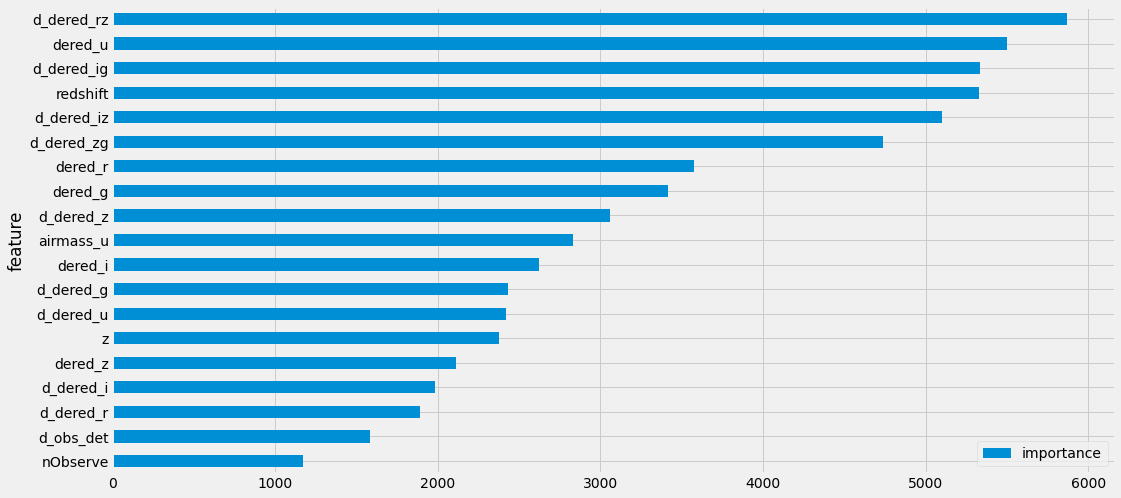

In [19]:
imp = pd.DataFrame({'feature': df.columns, 'importance': clf.feature_importances_})
imp = imp.sort_values('importance').set_index('feature')
imp.plot(kind='barh')

## 제출 파일 생성

In [20]:
sub = pd.read_csv(sample_file, index_col=0)
print(sub.shape)
sub.head()

(80000, 1)


,class
id,
320000,0
320001,0
320002,0
320003,0
320004,0


In [21]:
sub[target_col] = np.argmax(p_tst, axis=1)
sub.head()

,class
id,
320000,2
320001,0
320002,2
320003,0
320004,2


In [22]:
sub[target_col].value_counts()

2    41111
0    29973
1     8916
Name: class, dtype: int64

In [23]:
sub.to_csv(sub_file)